In [1213]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import sys

sys.path.append("..")
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.9.1


In [1214]:
##训练集
train_data = pd.read_csv(open('train.csv'))
##测试集
test_data = pd.read_csv(open('test.csv'))

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

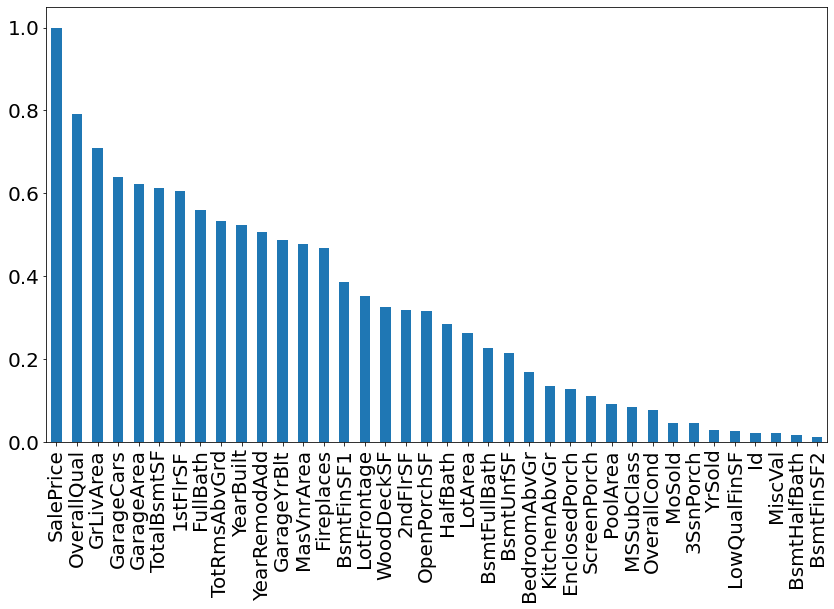

In [1215]:
#查看自变量与因变量的相关性
fig = plt.figure(figsize=(14, 8))
abs(train_data.corr()['SalePrice']).sort_values(ascending=False).plot.bar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

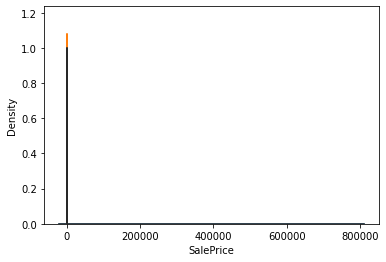

In [1216]:
#查看因变量是否符合正态分布
sns.distplot(train_data['SalePrice'], fit=norm)
sns.distplot(np.log(train_data['SalePrice']), fit=norm)  #取对数后的

<Figure size 432x288 with 0 Axes>

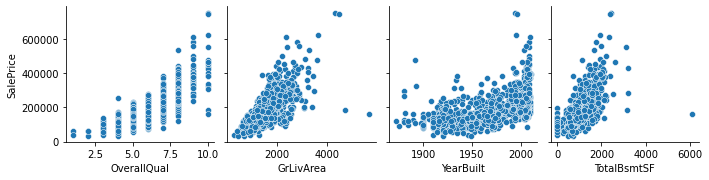

In [1217]:
#异常值处理
figure = plt.figure()
sns.pairplot(x_vars=['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF'],
             y_vars=['SalePrice'], data=train_data, dropna=True)
plt.show()

In [1218]:
#删除异常值
train_data = train_data.drop(train_data[(train_data['OverallQual'] < 5) &
                                        (train_data['SalePrice'] > 200000)].index)

train_data = train_data.drop(train_data[(train_data['GrLivArea'] > 4000) &
                                        (train_data['SalePrice'] < 300000)].index)

train_data = train_data.drop(train_data[(train_data['YearBuilt'] < 1900) &
                                        (train_data['SalePrice'] > 400000)].index)
train_data = train_data.drop(train_data[(train_data['TotalBsmtSF'] > 6000) &
                                        (train_data['SalePrice'] < 200000)].index)

<Figure size 432x288 with 0 Axes>

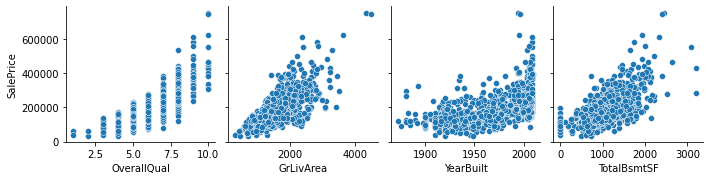

In [1219]:
#检查是否还存在异常值
figure = plt.figure()
sns.pairplot(x_vars=['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF'],
             y_vars=['SalePrice'], data=train_data, dropna=True)
plt.show()

In [1220]:
#去掉Id和SalePrice,将训练集和测试集的79个特征按样本连接
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [1221]:
#观察数据的缺失情况
nan_index = ((all_features.isnull().sum() / len(all_features))).sort_values(ascending=False)  #34个缺失值

In [1222]:
#将列表中数值型的数据索引出来
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
#对数据进行标准化
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
#标准化后，每个数值特征的均值变为0，可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)
#离散数值转成指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)  #通过转换将特征数从79增加到了330

In [1223]:
#先把合并的数据集重新分割为训练集和测试集
n_train = train_data.shape[0]
#通过values属性得到Numpy格式的数据，并转成Tensor方便后面的训练
#训练样本特征
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
#测试样本特征
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
#训练样本标签
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)
# print(train_labels)
train_labels = train_labels.log1p()
# train_labels = train_labels.expm1()
# print(train_labels)

In [1224]:
#定义均方误差损失函数
loss = torch.nn.MSELoss()

In [1225]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()

    def forward(self, x):  # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

In [1226]:
#定义线性回归模型
def get_net(feature_num):
    net = nn.Sequential(
        FlattenLayer(),
        nn.Linear(feature_num, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
    )
    #模型参数初始化
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [1227]:
#对数均方误差的实现
def log_rmse(net, features, labels):
    with torch.no_grad():
        #将小于1的值设成1，使的取对数时数值更稳定
        # clipped_preds = torch.max(net(features), torch.tensor(1.0))
        clipped_preds = net(features)
        rmse = torch.sqrt(loss(clipped_preds, labels))
        # rmse = torch.sqrt(loss(clipped_preds, labels))
        # rmse = loss(clipped_preds,labels)
        # print(torch.sqrt(loss(clipped_preds,labels)))
    return rmse.item()

In [1228]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    #把dataset放入DataLoader
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    #这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    net = net.float()  #将神经网络中的数据类型设置维浮点型
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [1229]:
# 本函数已保存在d2lzh包中方便以后使用
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    plt.subplots(figsize=figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [1230]:
#K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        #划分出验证数据集
        if j == 1:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        #划分出训练数据，剩下的进行合并
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            #dim=0按列合并
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k) :
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        #误差累计
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls,
                     'epochs', 'rmse',
                     range(1, num_epochs + 1), valid_ls,
                     ['train', 'valid'])
            #输出相应的结果：训练误差、验证误差
        print('fold%d,train rmse %f,valid rmse %f' %
              (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold0,train rmse 0.088420,valid rmse 0.147363
fold1,train rmse 0.085400,valid rmse 0.173469
fold2,train rmse 0.086144,valid rmse 0.156078
fold3,train rmse 0.092913,valid rmse 0.157090
fold4,train rmse 0.103345,valid rmse 0.127893
fold5,train rmse 0.096057,valid rmse 0.232683
fold6,train rmse 0.064737,valid rmse 0.167438
fold7,train rmse 0.083538,valid rmse 0.144376
8-fold validation:avg trian rmse 0.087569,avg valid rmse 0.163299


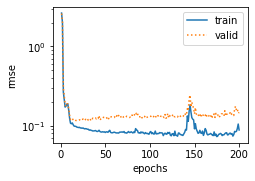

In [1231]:
#模型选择
k = 8
num_epochs = 200
lr = 0.005
weight_decay = 0
batch_size = 128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation:avg trian rmse %f,avg valid rmse %f' %
      (k, train_l, valid_l))

In [1232]:
#模型预测
def train_and_pred(train_features, test_features, train_labeld, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    #第二个变量（测试误差）缺省，用_代替
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = np.expm1(net(test_features).detach().numpy())
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission_deep_learning_ori.csv', index=False)
    return net

train rmse 0.097430


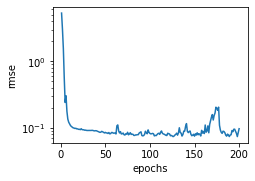

In [1233]:
net = train_and_pred(train_features, test_features, train_labels,
               test_data, num_epochs, lr, weight_decay, batch_size)

In [1234]:
for name, parameters in net.named_parameters():
    print(name, ':', parameters.size())

1.weight : torch.Size([256, 330])
1.bias : torch.Size([256])
3.weight : torch.Size([1, 256])
3.bias : torch.Size([1])
